### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dynamic Time Warping

In [3]:
def dynamic_time_warping(a, b):
    n = len(a)
    m = len(b)

    distances_row_1 = np.zeros(m)
    distances_row_2 = np.zeros(m)

    distances_row_1[:] = np.cumsum((a[0] - b[:]) ** 2)

    for i in range(1, n):
        distances_row_2[0] = (a[i] - b[0]) ** 2 + distances_row_1[0]
        for j in range(1, m):
            distances_row_2[j] = (a[i] - b[j]) ** 2 + min(distances_row_2[j - 1], min(distances_row_1[j - 1], distances_row_1[j]))
        distances_row_1[:] = distances_row_2

    return np.sqrt(distances_row_1[m - 1])

## Principal Component Analysis

In [4]:
def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))
    df = df.values.T.astype(float)
    # zero-mean the data
    for i in range(df.shape[0]):
        df[i] = df[i] - np.mean(df[i])

    # define covariance matrix
    cov = 1 / df.shape[0] * df @ df.T

    evl, evec = np.linalg.eig(cov)
    d = {}
    for i in range(evl.size):
        d[evl[i]] = evec[:,i]
    evls = np.sort(np.unique(evl))[::-1]
    for i in range(k):
        eigenvectors[:,i] = d[evls[i]]

    return eigenvectors  # eigenvectors


def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))
    df = df.T.values.astype(float)
    for i in range(df.shape[0]):
        df[i] = df[i] - np.mean(df[i])

    df = df.T
    projected_data = df@eigenvectors
    return pd.DataFrame(projected_data)

## Familiarization

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [5]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [6]:
def visualize_sensor_data(df, window=None, sensors=None, normalized=False):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        sensor_data = df[sensor][start_index:end_index]
        if normalized:
            sensor_data = (sensor_data - sensor_data.mean()) / (sensor_data.std() + 1e-9)
        plt.plot(df['Timestamp'][start_index:end_index], sensor_data, label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

C:\Users\vladu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


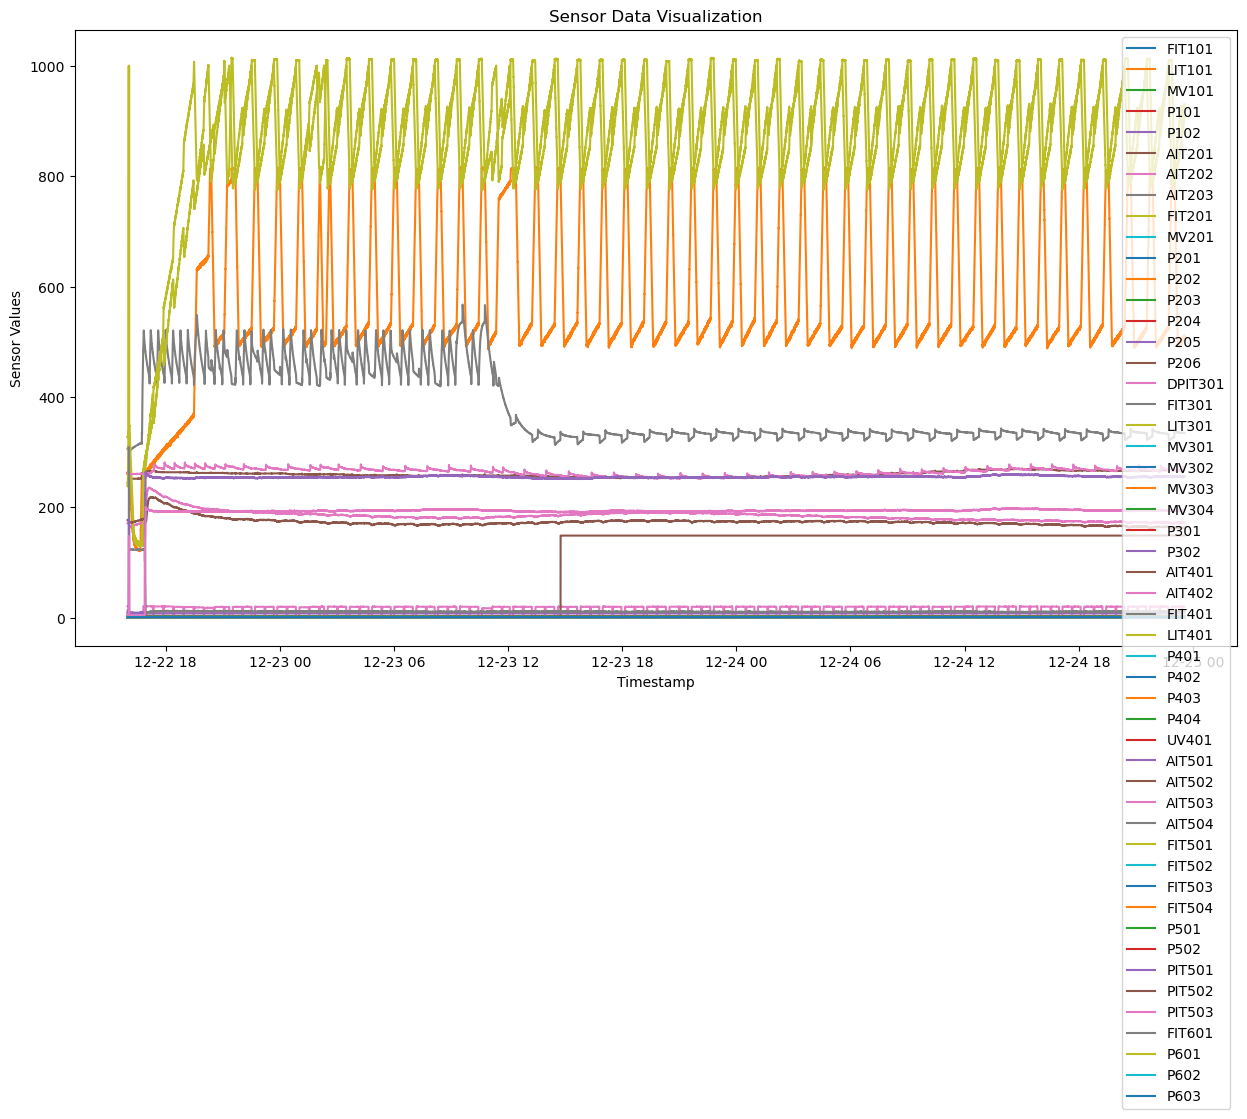

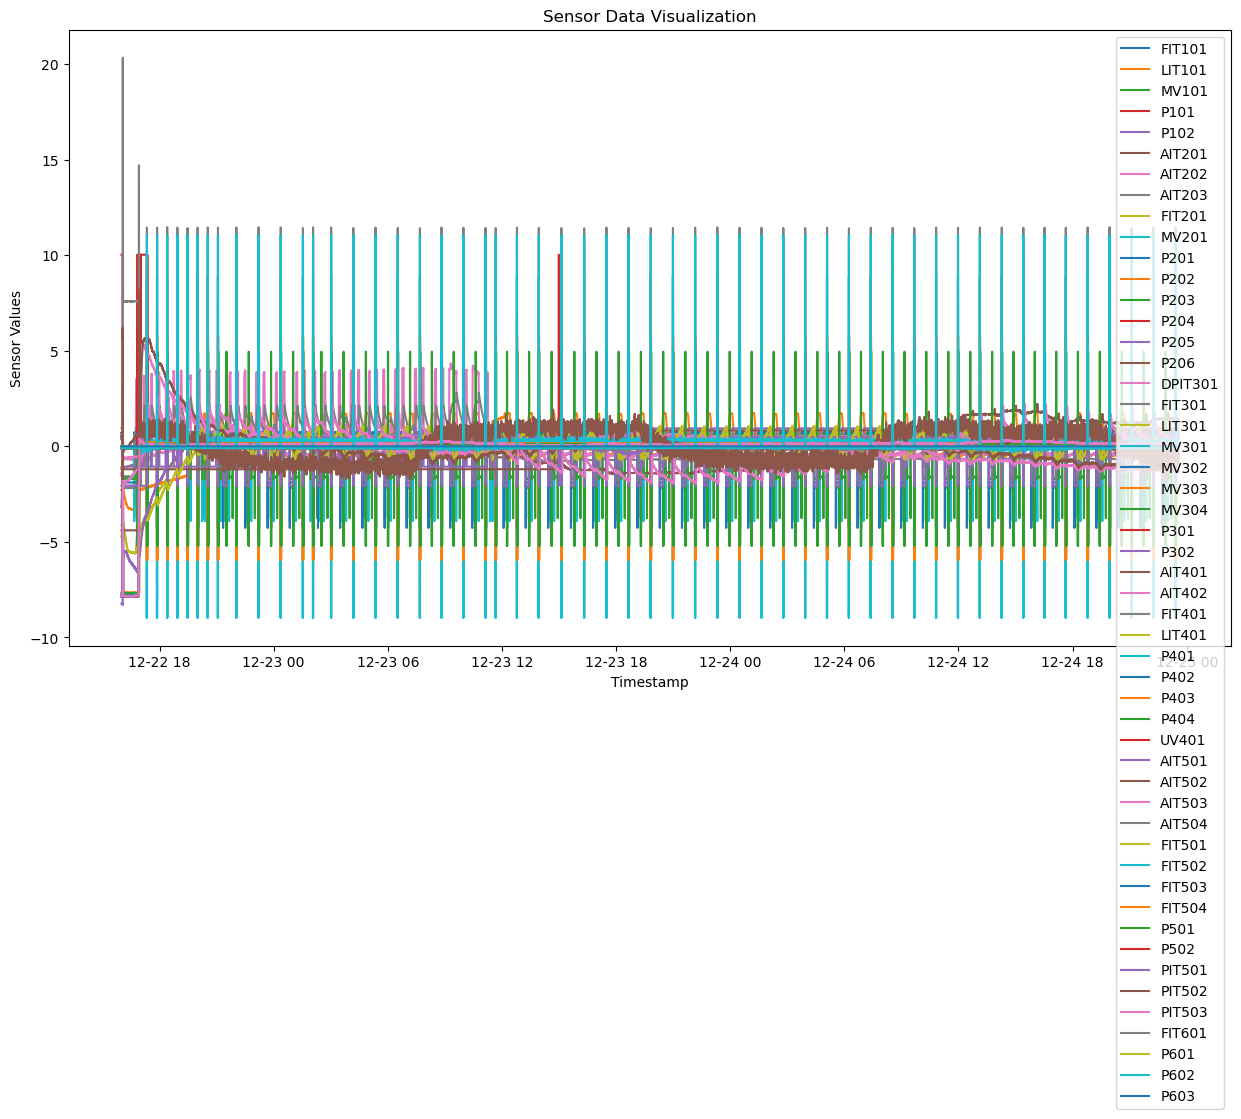

In [7]:
# Visualize first 200000 measurements from each sensor
visualize_sensor_data(train_data, window=(0, 200000))

# Visualize first 200000 normalized measurements from each sensor
visualize_sensor_data(train_data, window=(0, 200000), normalized=True) # TODO do we need this?

### Types of signals
From the visualization, we can see there are 2 types of signals based on their values: continuously-valued and discretely-valued.
An example of a signal with continuous values can be seen in the following cell.

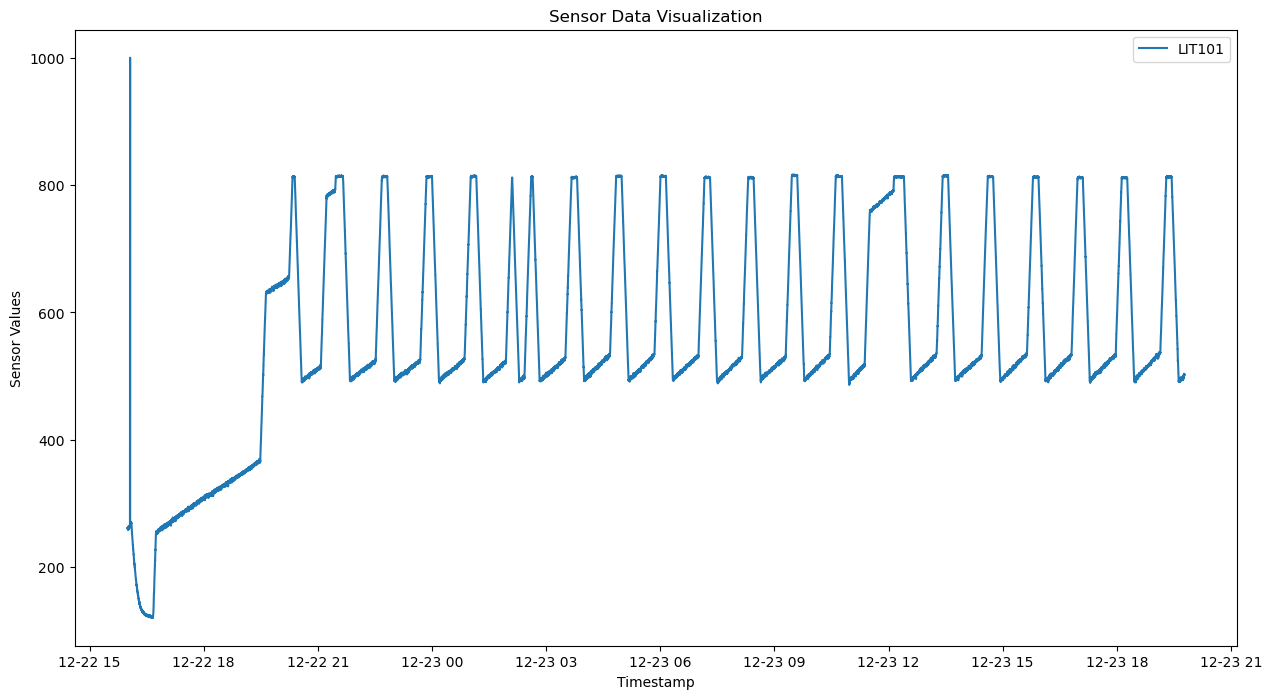

In [8]:
visualize_sensor_data(train_data, window=(0, 100000), sensors=["LIT101"])

An example of a signal with discrete values can be seen in the following cell.

Measurements from MV101 take values from [0 1 2]


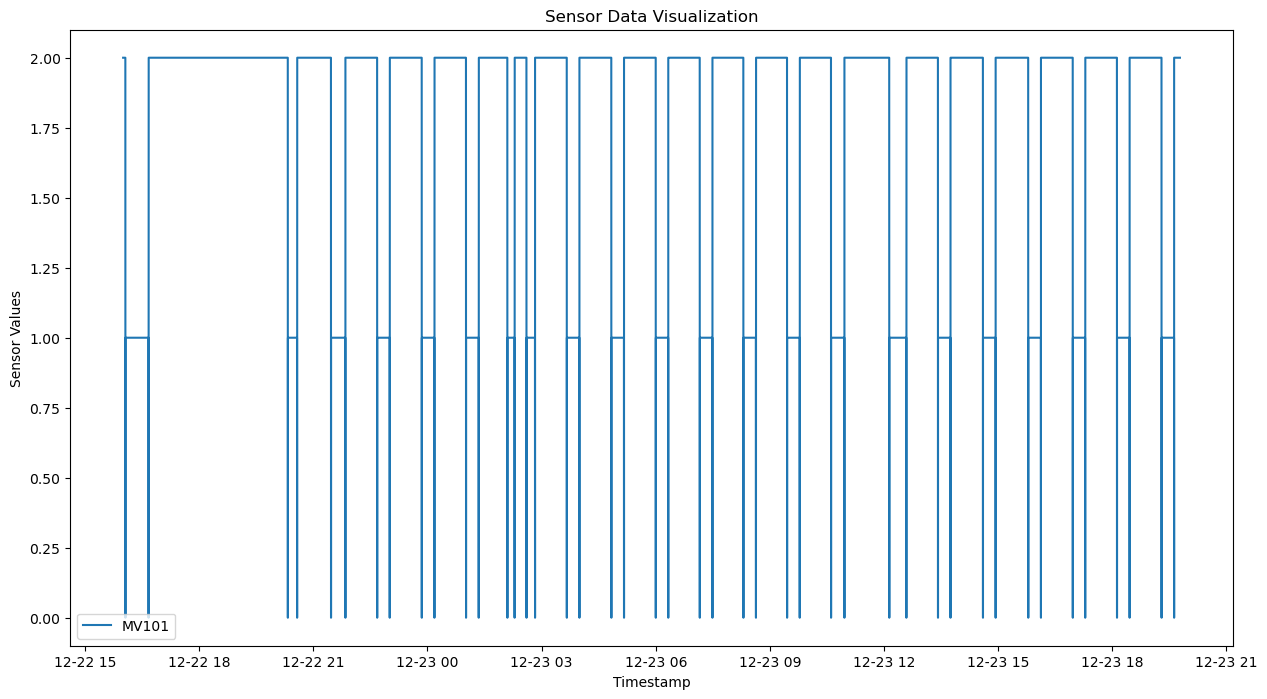

In [9]:
MV101_values = np.unique(train_data['MV101'])
print(f'Measurements from MV101 take values from {MV101_values}')
visualize_sensor_data(train_data, window=(0, 100000), sensors=["MV101"])

## DTW-based anomaly detection
Below we are running an experiment on a single sensor. First, we are normalizing both the train and test data.

In [1]:
# experiment parameters
window_size = 1000
window_jump = 500
sensor_experiment = "FIT101"

# normalize sensor train data
train_data_experiment = train_data[sensor_experiment]
train_data_experiment = (train_data_experiment - train_data_experiment.mean()) / (train_data_experiment.std() + 1e-9)
visualize_sensor_data(train_data, sensors=[sensor_experiment], normalized=True)

# normalize sensor test data
test_data_experiment = test_data[sensor_experiment]
test_data_experiment = (test_data_experiment - test_data_experiment.mean()) / (test_data_experiment.std() + 1e-9)
visualize_sensor_data(test_data, sensors=[sensor_experiment], normalized=True)

# sample representative windows
representative_windows = np.lib.stride_tricks.sliding_window_view(train_data_experiment, window_shape=window_size)[:: 5*window_size, ::10] # tumbling windows with skip of 2
# so a representative window has size 1000 now
print(f'We have {representative_windows.shape[0]} representative windows of size {representative_windows.shape[1]} each.')

NameError: name 'train_data' is not defined

We have 88 test sliding windows of size 1000 each.


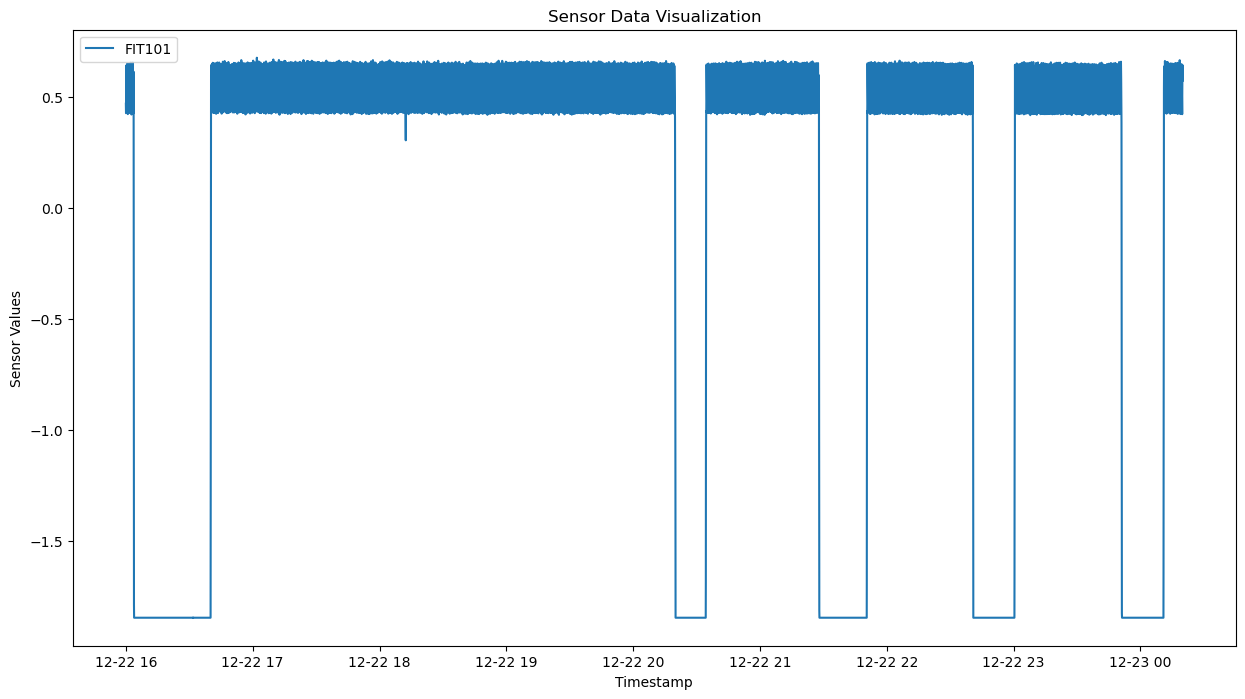

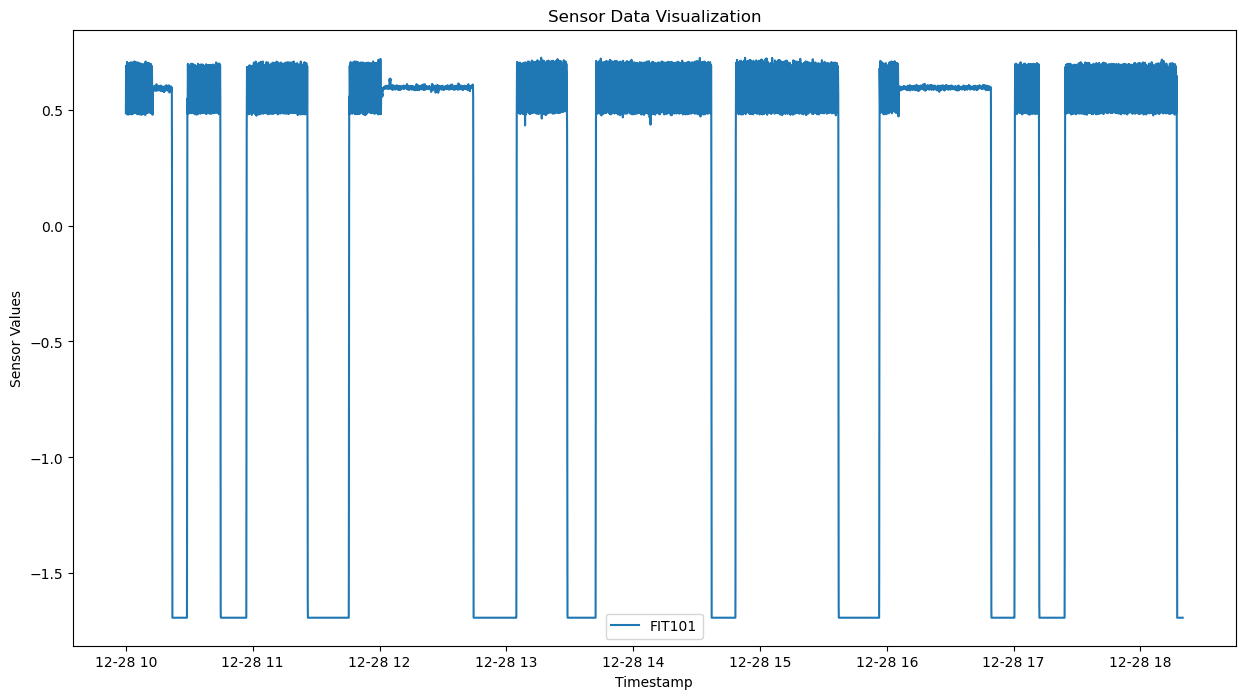

->  8.242961026895072
->  4.142678487184561
->  13.852581998564247
->  3.8947295328912603
->  8.944100783358731
->  10.390858576058951
->  12.637948617903136
->  3.9650378938485544
->  6.7339406119029945


KeyboardInterrupt: 

In [44]:
train_windows = np.lib.stride_tricks.sliding_window_view(train_data_experiment, window_shape=window_size)[::window_jump, ::10]
test_windows = np.lib.stride_tricks.sliding_window_view(test_data_experiment, window_shape=window_size)[::window_jump, ::10]
print(f'We have {test_windows.shape[0]} test sliding windows of size {test_windows.shape[1]} each.')

visualize_sensor_data(train_data, window=(0, 30000), sensors=[sensor_experiment], normalized=True)
visualize_sensor_data(test_data, window=(0, 30000), sensors=[sensor_experiment], normalized=True)

residuals = []

for test_window in test_windows:
    residual = 2e9
    x = []
    for representative_window in representative_windows:
        # plt.plot(representative_window)
        # plt.show()
        dtw = dynamic_time_warping(test_window, representative_window)
        # print(dtw)
        # if dtw < residual:
        #     x = representative_window
        residual = min(residual, dtw)
    residuals.append(residual)
    # plt.plot(test_window)
    # plt.plot(x)
    # plt.show()
    print("-> ", residual)
    
residuals2 = []

for train_window in train_windows:
    residual = 2e9
    for representative_window in representative_windows:
        dtw = dynamic_time_warping(train_window, representative_window)
        residual = min(residual, dtw)
    residuals2.append(residual)

plt.plot(residuals2) # train
plt.plot(residuals) # test
plt.show()